In [1]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

import pathlib
import os, sys


In [2]:
# data download


# path_2_zip = tf.keras.utils.get_file('spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
#     extract=True)

# path_2_file = pathlib.Path(path_2_zip).parent/'spa-eng/spa.txt'

# print(path_2_file)
# print(path_2_zip)

In [3]:
#data path
fileDir = os.path.dirname(os.path.realpath('__file__'))
filename = pathlib.Path(os.path.join(fileDir, r"dataset\spa.txt"))

print(filename)

F:\program repo\NLP-translation\dataset\spa.txt


In [4]:
def load_data(path):
    text = path.read_text(encoding='utf-8')

    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]

    context = np.array([context for target, context in pairs])
    target = np.array([target for target, context in pairs])

    return target, context



In [5]:
target_raw, context_raw = load_data(filename)

In [6]:
#check data
print(target_raw[0])
print(context_raw[0])

Go.
Ve.


In [7]:
#meta data

max_vocab_size = 5000

buffer_size = len(context_raw)
batch_size = 64

train_set_proportion = 0.8

is_train = np.random.uniform(size=(len(target_raw), )) < train_set_proportion



In [8]:
class ShapeChecker():
    def __init__(self):
        # Keep a cache of every axis-name seen
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        parsed = einops.parse_shape(tensor, names)

        for name, new_dim in parsed.items():
            old_dim = self.shapes.get(name, None)

            if (broadcast and new_dim == 1):
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                    f"    found: {new_dim}\n"
                                    f"    expected: {old_dim}\n")

In [9]:
#set up tf dataset
train_set_raw = (
    tf.data.Dataset.from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(buffer_size)
    .batch(batch_size)
)

val_set_raw = (
    tf.data.Dataset.from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(buffer_size)
    .batch(batch_size)
)

In [10]:
#data check

for context_strings, target_strings in train_set_raw.take(1):
    print(context_strings[:6])
    print()
    print(target_strings[:6])
    break

tf.Tensor(
[b'Pronto ser\xc3\xa1 Navidad.'
 b'Tom llam\xc3\xb3 a Mary para disculparse, pero le colg\xc3\xb3.'
 b'Alguien tom\xc3\xb3 mis zapatos por error.'
 b'El perro sigui\xc3\xb3 a su amo, moviendo la cola.'
 b'Fui incapaz de mirarle a la cara.'
 b'Esta semana ha sido una maravillosa experiencia.'], shape=(6,), dtype=string)

tf.Tensor(
[b'Christmas is coming.'
 b'Tom called Mary to apologize to her, but she hung up on him.'
 b'Someone has taken my shoes by mistake.'
 b'The dog followed its master, wagging its tail.'
 b'I was unable to look her in the face.'
 b'This week has been an amazing experience.'], shape=(6,), dtype=string)


In [11]:
def tf_lower_and_split_punct(text):
    #split accented characters
    text = tf_text.normalize_utf8(text, 'NFKD') #NFKD is one of the normalization format defined in unicode convention
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text


In [12]:
#check

example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

print(example_text.numpy().decode())

print(tf_lower_and_split_punct(example_text).numpy().decode())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'
¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


In [13]:
#Text vectoriazation

context_text_preprocessor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True
)

In [14]:
context_text_preprocessor.adapt(train_set_raw.map(lambda context, target: context))

In [15]:
#output check
context_text_preprocessor.get_vocabulary()[:15]

['',
 '[UNK]',
 '[START]',
 '[END]',
 '.',
 'que',
 'de',
 'el',
 'a',
 'no',
 'tom',
 'la',
 '?',
 '¿',
 'en']

In [16]:
target_text_preprocessor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True
)



In [17]:
target_text_preprocessor.adapt(train_set_raw.map(lambda context, target: target))

In [18]:
#output check
target_text_preprocessor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [19]:
example_tokens = context_text_preprocessor(context_strings)
print(example_tokens[ : 3])

<tf.RaggedTensor [[2, 216, 362, 496, 4, 3],
 [2, 10, 591, 8, 32, 31, 1, 19, 96, 28, 2470, 4, 3],
 [2, 153, 453, 126, 384, 21, 383, 4, 3]]>


In [20]:
#convert token value back to words

context_vocab = np.array(context_text_preprocessor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
print(' '.join(tokens))


target_vocab = np.array(target_text_preprocessor.get_vocabulary())
tk2 = target_vocab[target_text_preprocessor(target_strings)[0].numpy()]
print(' '.join(tk2))

[START] pronto sera navidad . [END]
[START] christmas is coming . [END]


Text(0.5, 1.0, 'Mask')

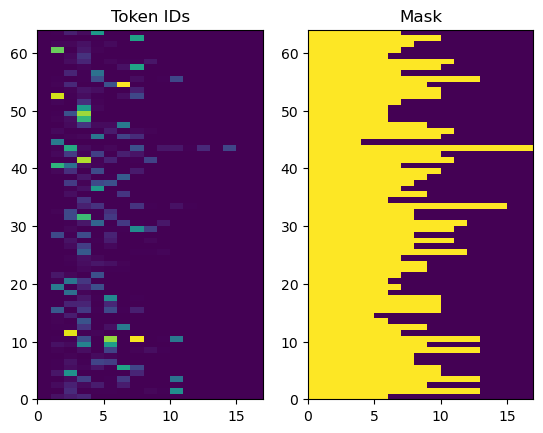

In [21]:
# visualization

plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [22]:
def process_text(context, target):
    context = context_text_preprocessor(context).to_tensor()
    target = target_text_preprocessor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:,1:].to_tensor()
    return (context, targ_in), targ_out

train_ds = train_set_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_set_raw.map(process_text, tf.data.AUTOTUNE)

In [23]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy())

[  2  94 117   8 347  14 133 297   4   3]

[  2   9  49  35 118  14 156 374   4   0]
[  9  49  35 118  14 156 374   4   3   0]


# ENCODER

In [54]:
units = 256 #units of the rnn layer (256 is good enough for this dataset, 1024)

In [25]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_preprocessor, units):
        super(Encoder, self).__init__()
        self.text_preprocessor = text_preprocessor
        self.vocab_size = text_preprocessor.vocabulary_size()
        self.units = units
    

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

        # The RNN layer processes those vectors sequentially.

        # self.rnn = tf.keras.layers.LSTM(
        #     units,
        #     return_sequences=True,
        #     recurrent_initializer='glorot_uniform'
        # )

        self.rnn = tf.keras.layers.Bidirectional(
            layer=tf.keras.layers.GRU(
                units,
                return_sequences=True,
                recurrent_initializer='glorot_uniform'
            )
        )


    def call(self, x):
        # shape_checker = ShapeChecker() 
        # shape_checker(x, 'batch s')

        # 2. The embedding layer looks up the embedding vector for each token.
        x = self.embedding(x)
        # shape_checker(x, 'batch s units embedding')

        # 3. The GRU processes the sequence of embeddings.
        x = self.rnn(x)
        # shape_checker(x, 'batch s units rnn')

        # 4. Returns the new sequence of embeddings.
        return x

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)

        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_preprocessor(texts).to_tensor()
        context = self(context)
        return context

In [26]:
#testing

encoder = Encoder(context_text_preprocessor, units)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 19)
Encoder output, shape (batch, s, units): (64, 19, 2048)


In [27]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, context):

        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        attn_scores = tf.reduce_mean(attn_scores, axis=1)

        self.last_attention_weights = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x
        
        

In [28]:
attention_layer = CrossAttention(units)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_preprocessor.vocabulary_size(),
                                  output_dim=units, mask_zero=True)


ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 19, 2048)
Target sequence, shape (batch, t, units): (64, 15, 1024)
Attention result, shape (batch, t, units): (64, 15, 1024)
Attention weights, shape (batch, t, s):    (64, 15, 19)


In [29]:
#check attention layer sum, 
# The attention weights will sum to 1 over the context sequence, at each location in the target sequence.
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 0.9999999 , 1.        , 1.        , 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994],
      dtype=float32)

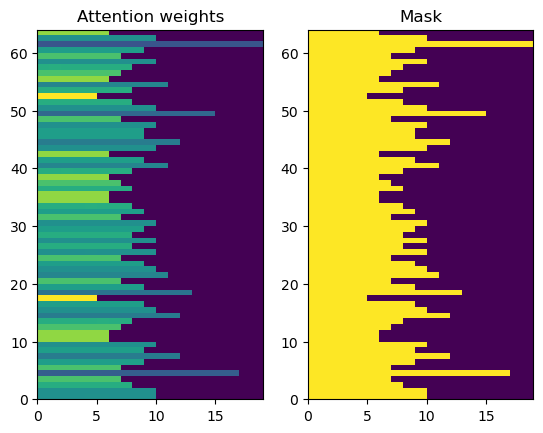

In [30]:
# plot attention weight
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

In [31]:
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units):
        super(Decoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]',
            invert=True)
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

        self.units = units

        # 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                                units, mask_zero=True)

        # 2. The RNN keeps track of what's been generated so far.
        self.rnn = tf.keras.layers.GRU(units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')

        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)

        # 4. This fully connected layer produces the logits for each
        # output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)


In [32]:
@Decoder.add_method
def call(self,
            context, x,
            state=None,
            return_state=False):  
    # shape_checker = ShapeChecker()
    # shape_checker(x, 'batch t')
    # shape_checker(context, 'batch s units')

    # 1. Lookup the embeddings
    x = self.embedding(x)
    # shape_checker(x, 'batch t units')

    # 2. Process the target sequence.
    x, state = self.rnn(x, initial_state=state)
    # shape_checker(x, 'batch t units')

    # 3. Use the RNN output as the query for the attention over the context.
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights
    # shape_checker(x, 'batch t units')
    # shape_checker(self.last_attention_weights, 'batch t s')

    # Step 4. Generate logit predictions for the next token.
    logits = self.output_layer(x)
    # shape_checker(logits, 'batch t target_vocab_size')

    if return_state:
        return logits, state
    else:
        return logits

In [33]:
decoder = Decoder(target_text_preprocessor, units)

In [34]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 19, 2048)
input target tokens shape: (batch, t) (64, 15)
logits shape shape: (batch, target_vocabulary_size) (64, 15, 5000)


In [35]:
@Decoder.add_method
def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [36]:
@Decoder.add_method
def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
    return result

In [37]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(
        context, next_token,
        state = state,
        return_state=True) 

    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
    else:
        logits = logits[:, -1, :]/temperature
        next_token = tf.random.categorical(logits, num_samples=1)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    return next_token, done, state

In [38]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
    # Run one step.
    next_token, done, state = decoder.get_next_token(
        ex_context, next_token, done, state, temperature=1.0)
    # Add the token to the output.
    tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'practically guests feeding beggar founded cure laughter handy christians occurred',
       b'orange surface baffled intentionally spouse reservation action visiting tend telescope',
       b'jesus unattended chips temporary apologized decide back appropriate succeeded bones'],
      dtype=object)

In [39]:
class Translator(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, units,
                context_text_processor,
                target_text_processor):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(context_text_processor, units)
        decoder = Decoder(target_text_processor, units)

        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(context, x)

        try:
            # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

In [40]:
#translator inference method
@Translator.add_method
def translate(self,
                texts, *,
                max_length=50,
                temperature=0.0):
    # Process the input texts
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]

    # Setup the loop inputs
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)

    for _ in range(max_length):
        # Generate the next token
        next_token, done, state = self.decoder.get_next_token(
            context, next_token, done,  state, temperature)

        # Collect the generated tokens
        tokens.append(next_token)
        attention_weights.append(self.decoder.last_attention_weights)

        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

    result = self.decoder.tokens_to_text(tokens)
    return result

In [41]:
#Use that to generate the attention plot:
@Translator.add_method
def plot_attention(self, text, **kwargs):
    assert isinstance(text, str)
    output = self.translate([text], **kwargs)
    output = output[0].numpy().decode()

    attention = self.last_attention_weights[0]

    context = tf_lower_and_split_punct(text)
    context = context.numpy().decode().split()

    output = tf_lower_and_split_punct(output)
    output = output.numpy().decode().split()[1:]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    ax.matshow(attention, cmap='viridis', vmin=0.0)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + output, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')

In [42]:
#training precheck
model = Translator(units, context_text_preprocessor, target_text_preprocessor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 19)
Target tokens, shape: (batch, t) (64, 15)
logits, shape: (batch, t, target_vocabulary_size) (64, 15, 5000)


In [43]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [44]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [45]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

## Training precheck

In [46]:
vocab_size = 1.0 * target_text_preprocessor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [47]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 4s 19ms/step - loss: 8.5389 - masked_acc: 9.1408e-05 - masked_loss: 8.5389


{'loss': 8.538928031921387,
 'masked_acc': 9.140768088400364e-05,
 'masked_loss': 8.538928031921387}

In [48]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=4)])

Epoch 1/100
100/100 [==============================] - 11s 43ms/step - loss: 4.1168 - masked_acc: 0.3760 - masked_loss: 4.1168 - val_loss: 3.2536 - val_masked_acc: 0.4653 - val_masked_loss: 3.2536
Epoch 2/100
100/100 [==============================] - 4s 39ms/step - loss: 2.9070 - masked_acc: 0.5110 - masked_loss: 2.9070 - val_loss: 2.5589 - val_masked_acc: 0.5502 - val_masked_loss: 2.5589
Epoch 3/100
100/100 [==============================] - 4s 40ms/step - loss: 2.4334 - masked_acc: 0.5743 - masked_loss: 2.4334 - val_loss: 2.3104 - val_masked_acc: 0.5962 - val_masked_loss: 2.3104
Epoch 4/100
100/100 [==============================] - 4s 40ms/step - loss: 2.1388 - masked_acc: 0.6174 - masked_loss: 2.1388 - val_loss: 2.0180 - val_masked_acc: 0.6316 - val_masked_loss: 2.0180
Epoch 5/100
100/100 [==============================] - 4s 41ms/step - loss: 1.9459 - masked_acc: 0.6442 - masked_loss: 1.9459 - val_loss: 1.8496 - val_masked_acc: 0.6518 - val_masked_loss: 1.8496
Epoch 6/100
100/100

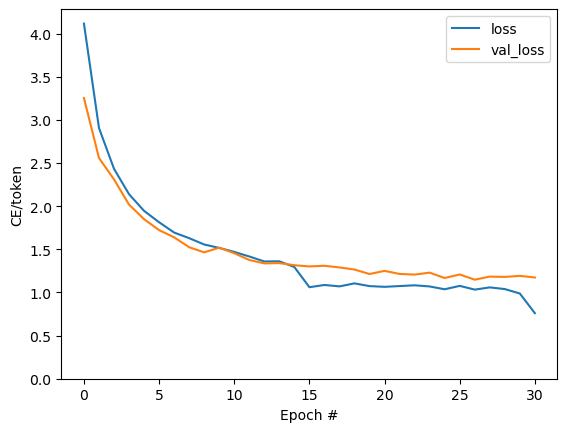

In [49]:
#plotting training history
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

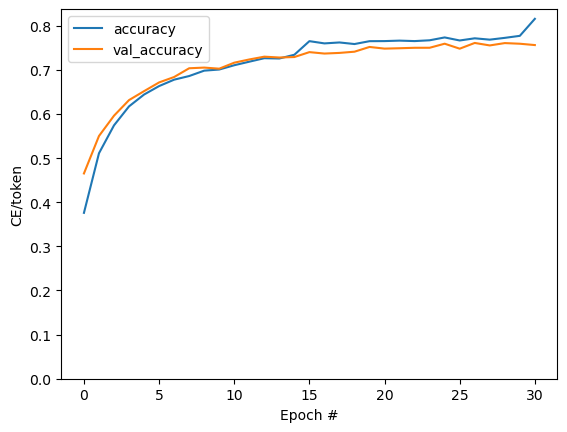

In [50]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

# Model Inference and Attention evaluation

In [51]:
result = model.translate(['¿Todavía está en casa?']) # Are you still home
result[0].numpy().decode()

'is he still at home ? '

C:\Users\Vincent\AppData\Local\Temp\ipykernel_12376\4066418792.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\Vincent\AppData\Local\Temp\ipykernel_12376\4066418792.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


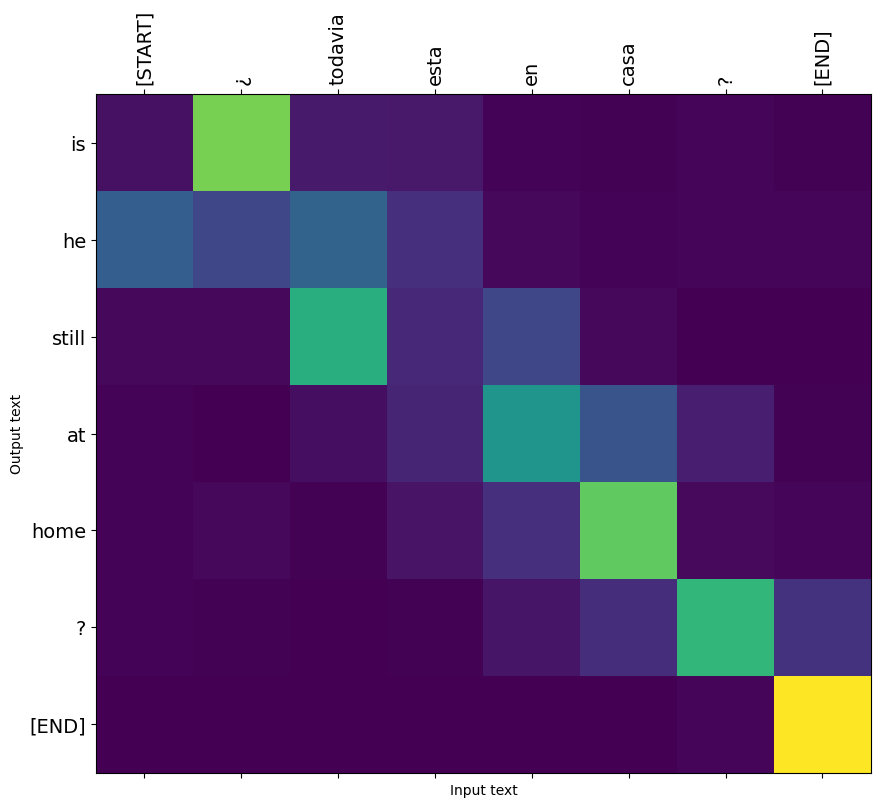

In [52]:
model.plot_attention('¿Todavía está en casa?') # Are you still home

CPU times: total: 125 ms
Wall time: 144 ms


C:\Users\Vincent\AppData\Local\Temp\ipykernel_12376\4066418792.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\Vincent\AppData\Local\Temp\ipykernel_12376\4066418792.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


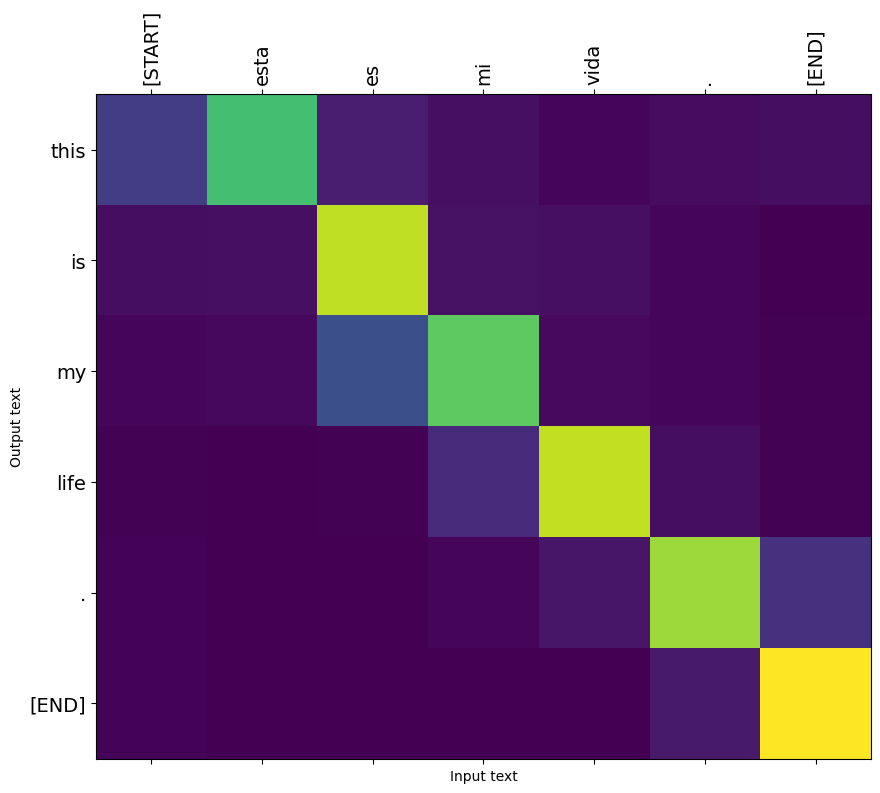

In [53]:
%%time
# This is my life.
model.plot_attention('Esta es mi vida.')